# Customer Segmentation with Unsupervised Learning

# Business Problem
**FLO wants to segment its customers and develop marketing strategies based on these segments. To achieve this, customer behaviors will be defined and groups will be created based on clustering within these behaviors.**

| **Variable Name**                 | **Description**                                                                 |
|-----------------------------------|---------------------------------------------------------------------------------|
| master_id                         | Unique customer number                                                          |
| order_channel                     | The platform channel used for the shopping (Android, iOS, Desktop, Mobile)      |
| last_order_channel                | The channel used for the last purchase                                          |
| first_order_date                  | The date of the customer's first purchase                                       |
| last_order_date                   | The date of the customer's last purchase                                        |
| last_order_date_online            | The date of the customer's last online purchase                                 |
| last_order_date_offline           | The date of the customer's last offline purchase                                |
| order_num_total_ever_online       | The total number of purchases made by the customer on the online platform       |
| order_num_total_ever_offline      | The total number of purchases made by the customer on the offline platform      |
| customer_value_total_ever_offline | The total amount spent by the customer in offline purchases                     |
| customer_value_total_ever_online  | The total amount spent by the customer in online purchases                      |
| interested_in_categories_12       | The list of categories the customer has shopped in the last 12 months           |

# importings

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler 
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer 
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
import warnings
warnings.filterwarnings("ignore")

warnings.simplefilter(action='ignore', category=FutureWarning)

# load data

In [2]:
df = pd.read_csv("/Users/mustafaemircan/PycharmProjects/MiuulBootcamp/PROJECTS/Machine Learning PROJECT/Third Week Part - 1/flo_data_20k.csv")

In [3]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Duplicated Values #####################")
    print(dataframe.duplicated().sum())
    print("##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("##################### Number of Unique Values #####################")
    print(df.nunique())

check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Duplicated Values #####################
0
##################### Missing Values #####################
master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_

**Convert the type of date variables to datetime.**

In [5]:
for col in df.columns:
    if "date" in col:
        df[col] = pd.to_datetime(df[col])

In [6]:
df["last_order_date"].max()

Timestamp('2021-05-30 00:00:00')

In [7]:
from datetime import timedelta

selected_date= df["last_order_date"].max()+ timedelta(days=2)
selected_date

Timestamp('2021-06-01 00:00:00')

	•	Tenure: Customer’s tenure
	•	Recency: How many days ago the last purchase was made
	•	Frequency: Visit frequency (how many times they have visited)
	•	Total Value: The total amount paid to us in online + offline purchases

In [8]:
df["total_value"]=df["customer_value_total_ever_offline"]+df["customer_value_total_ever_online"]

df["frequency"]=df["order_num_total_ever_offline"]+ df["order_num_total_ever_online"]

In [9]:
df["tenure"]= (selected_date- df["first_order_date"]).dt.days 

df["recency"]= (selected_date- df["last_order_date"]).dt.days

In [10]:
df["frequency"]=df["frequency"].astype("int64")

In [12]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_value,frequency,tenure,recency
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],939.37,5,214,95
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.55,21,1574,105
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",585.32,5,552,186
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",121.97,2,146,135
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],209.98,2,668,86


# Customer Segmentation with K-Means

In [13]:
df_cluster=df[["total_value","frequency","tenure","recency"]]

In [14]:
df_cluster.head()

,total_value,frequency,tenure,recency
0,939.37,5,214,95
1,2013.55,21,1574,105
2,585.32,5,552,186
3,121.97,2,146,135
4,209.98,2,668,86


Standardize variables

In [16]:
sc = MinMaxScaler((0,1))
df_cluster = sc.fit_transform(df_cluster)
df_cluster[0:5]

array([[0.01950257, 0.015     , 0.06841244, 0.25479452],
       [0.04292553, 0.095     , 0.51358429, 0.28219178],
       [0.01178235, 0.015     , 0.17905074, 0.50410959],
       [0.0016788 , 0.        , 0.04615385, 0.36438356],
       [0.0035979 , 0.        , 0.21702128, 0.23013699]])

# model

In [17]:
kmeans_2 = KMeans(n_clusters=5, random_state=17).fit(df_cluster)
kmeans_2.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 5,
 'n_init': 'auto',
 'random_state': 17,
 'tol': 0.0001,
 'verbose': 0}

In [18]:
print("centers", kmeans_2.cluster_centers_)  # centers
print("cluster labels", kmeans_2.labels_)  # brings cluster labels
print(kmeans_2.inertia_)  # SSE, SSR: distances to the nearest cluster

centers [[0.02723741 0.03765901 0.60896192 0.18752763]
 [0.01113588 0.00928235 0.22482911 0.81677668]
 [0.01299954 0.01114836 0.20867967 0.42776699]
 [0.0160584  0.01435557 0.18906907 0.11211378]
 [0.01855231 0.02566254 0.64469848 0.70642882]]
cluster labels [3 0 2 ... 3 2 1]
380.48662986349484


# Determining the Optimum Number of Clusters

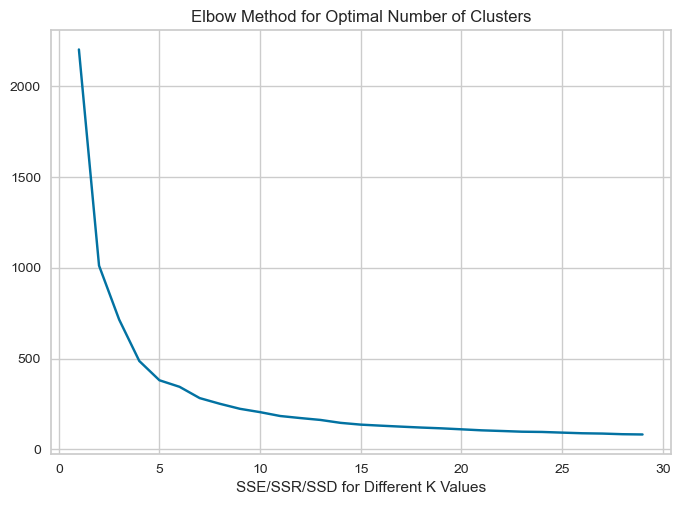

In [43]:
kmeans = KMeans()
ssd = []
K = range(1, 30)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(df_cluster)
    ssd.append(kmeans.inertia_)


plt.plot(K, ssd, "bx-")
plt.xlabel("SSE/SSR/SSD for Different K Values")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.show()

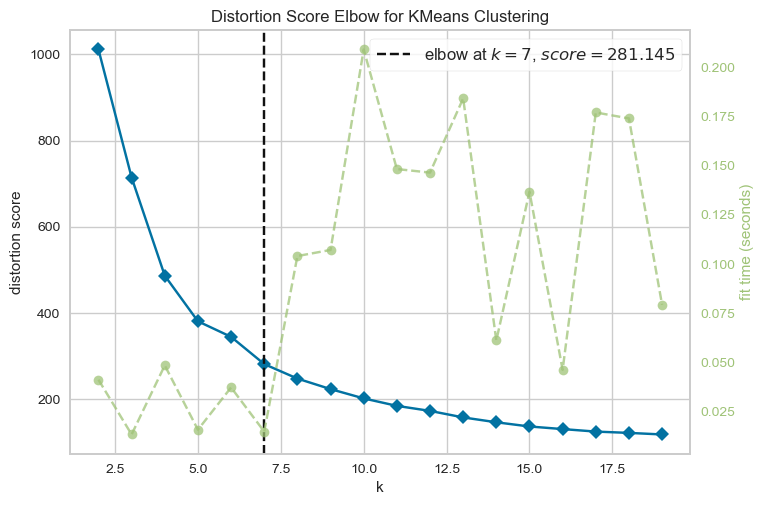

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df_cluster)
elbow.show()

In [21]:
elbow.elbow_value_

7

# Creating Final Clusters

In [23]:
kmeans = KMeans(n_clusters=elbow.elbow_value_, random_state=17).fit(df_cluster)

print("total cluster",kmeans.n_clusters)
print("cluster centers",kmeans.cluster_centers_ )
print("cluster labels", kmeans.labels_) 

total cluster 7
cluster centers [[0.02745924 0.03801524 0.61480081 0.18626128]
 [0.01099319 0.00914608 0.23115525 0.8823353 ]
 [0.01263028 0.01042527 0.21716674 0.5834789 ]
 [0.01403065 0.01266081 0.18694836 0.22648816]
 [0.01318795 0.01176491 0.2156641  0.38717323]
 [0.01878212 0.02617378 0.65872886 0.70564651]
 [0.01683666 0.0150133  0.1903761  0.06410824]]
cluster labels [3 0 2 ... 6 3 1]


In [24]:
clusters_kmeans = kmeans.labels_
df["kmeans_cluster_no"] = clusters_kmeans
df["kmeans_cluster_no"]= df["kmeans_cluster_no"] +1
df[df["kmeans_cluster_no"]==1].head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_value,frequency,tenure,recency,kmeans_cluster_no
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.55,21,1574,105,1
11,c2e15af2-9eed-11e9-9897-000d3a38a36f,Android App,Android App,2015-07-05,2021-05-19,2021-05-19,2020-07-10,19.0,1.0,90.49,2771.11,"[COCUK, KADIN, AKTIFSPOR]",2861.60,20,2158,13,1
27,c1f8f878-9f35-11e9-9897-000d3a38a36f,Mobile,Offline,2013-06-03,2021-03-01,2019-07-02,2021-03-01,3.0,1.0,40.87,90.00,[COCUK],130.87,4,2920,92,1
49,6925c836-ab8b-11e9-a2fc-000d3a38a36f,Ios App,Offline,2017-12-19,2021-04-22,2020-07-01,2021-04-22,2.0,4.0,572.56,167.97,"[ERKEK, COCUK]",740.53,6,1260,40,1
64,15fa60d6-9eb1-11e9-9897-000d3a38a36f,Mobile,Offline,2016-03-17,2021-02-02,2016-03-17,2021-02-02,1.0,3.0,320.85,43.19,"[AKTIFCOCUK, COCUK, KADIN, AKTIFSPOR]",364.04,4,1902,119,1


# We examine each segment statistically.

In [26]:
df.groupby("kmeans_cluster_no").agg({"total_value":"mean",
                                     "frequency":"mean",
                                     "tenure":"mean",
                                      "recency":"mean"})

,total_value,frequency,tenure,recency
kmeans_cluster_no,,,,
1,1303.728752,9.599878,1883.792326,70.095615
2,549.040737,3.827013,710.798466,324.036216
3,624.205985,4.085054,668.444376,214.969800
4,688.267666,4.529595,575.962617,84.601813
5,649.657600,4.353302,663.858067,143.287270
6,906.262696,7.237030,2016.308240,259.866734
7,817.431884,5.004754,586.667047,25.371554


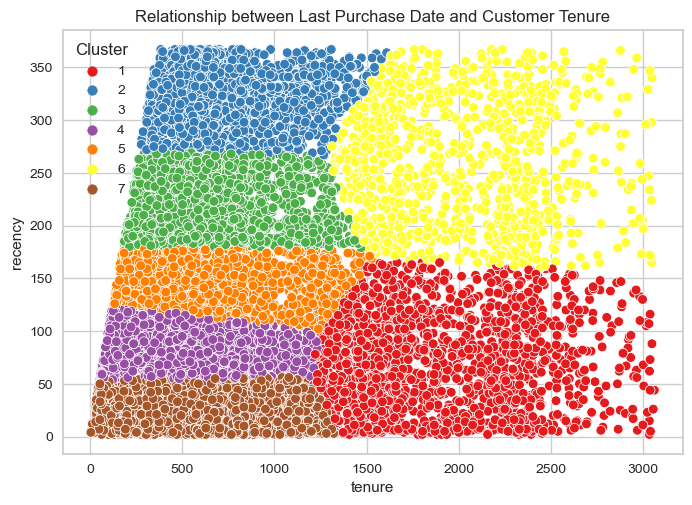

In [29]:
sns.scatterplot(data=df, x='tenure', y='recency', hue='kmeans_cluster_no', palette='Set1')
plt.xlabel('tenure')
plt.ylabel('recency')
plt.title('Relationship between Last Purchase Date and Customer Tenure')
plt.legend(title='Cluster')
plt.show()

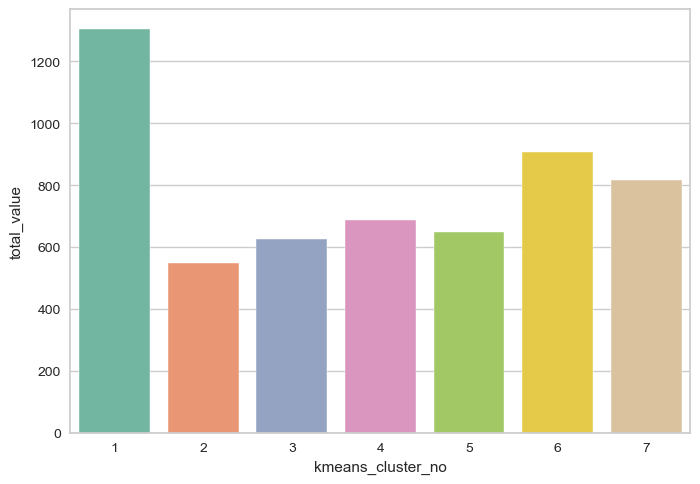

In [30]:
sns.barplot(data=df, x='kmeans_cluster_no', y='total_value',  ci=None, palette='Set2')
plt.show()

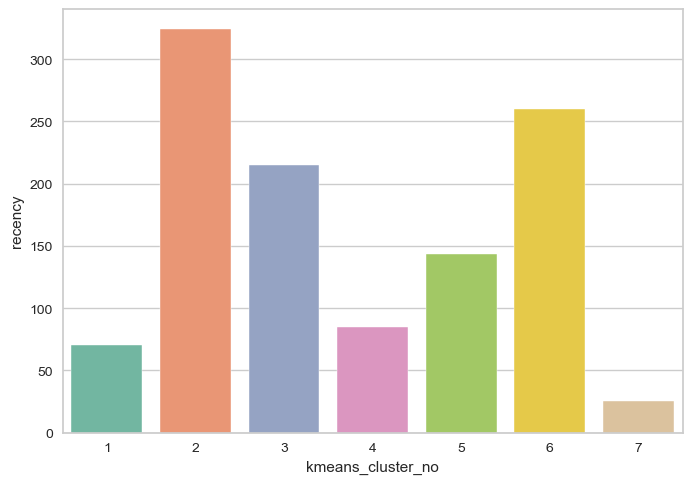

In [31]:
sns.barplot(data=df, x='kmeans_cluster_no', y='recency',  ci=None, palette='Set2')
plt.show()

# Hierarchical Clustering

In [32]:
df_cluster

array([[0.01950257, 0.015     , 0.06841244, 0.25479452],
       [0.04292553, 0.095     , 0.51358429, 0.28219178],
       [0.01178235, 0.015     , 0.17905074, 0.50410959],
       ...,
       [0.01282073, 0.005     , 0.20425532, 0.01643836],
       [0.02103767, 0.02      , 0.25924714, 0.29041096],
       [0.00473156, 0.        , 0.20687398, 0.98082192]])

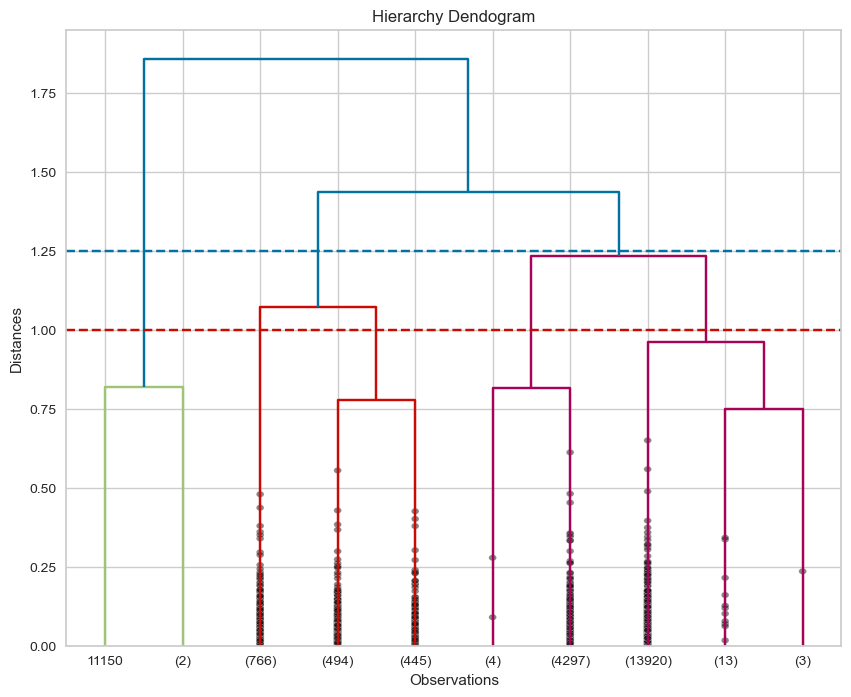

In [33]:
hc_complete = linkage(df_cluster, 'complete')
plt.figure(figsize=(10, 8))
plt.title("Hierarchy Dendogram")
plt.xlabel("Observations")
plt.ylabel("Distances")
dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)

plt.axhline(y=1, color='r', linestyle='--')
plt.axhline(y=1.25, color='b', linestyle='--')
plt.show()

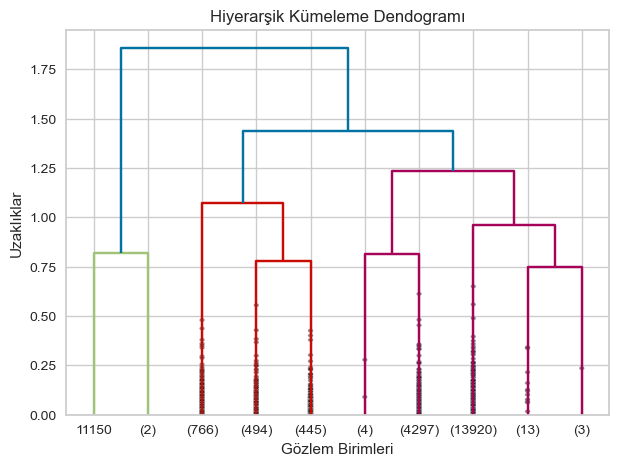

In [38]:
plt.figure(figsize=(7, 5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

# FINAL MODEL

**We set the number of clusters to 5.**

In [39]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, linkage="average")

clusters = cluster.fit_predict(df_cluster)

In [40]:
df["hi_cluster_no"] = clusters 
df["hi_cluster_no"] = df["hi_cluster_no"] + 1 
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_value,frequency,tenure,recency,kmeans_cluster_no,segment,hi_cluster_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],939.37,5,214,95,4,3,1
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.55,21,1574,105,1,0,1
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",585.32,5,552,186,3,2,1
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",121.97,2,146,135,5,4,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],209.98,2,668,86,4,3,1


In [42]:
df["hi_cluster_no"].value_counts()

hi_cluster_no
1    18554
5     1385
3        3
2        2
4        1
Name: count, dtype: int64

# For the Final Model, we examine each segment statistically.


In [41]:
df_hieracy=df[["total_value","frequency","tenure","recency","hi_cluster_no"]]

df_hieracy.groupby("hi_cluster_no").agg(["count","mean","median"])

total_value                         frequency              \
                    count          mean    median     count        mean   
hi_cluster_no                                                             
1                   18554    709.246683    532.94     18554    4.684812   
2                       2  23100.170000  23100.17         2  106.500000   
3                       3  29584.013333  31227.41         3   27.666667   
4                       1  45905.100000  45905.10         1  202.000000   
5                    1385   1186.532036    811.99      1385    9.241155   

                     tenure                      recency                     
              median  count         mean  median   count        mean median  
hi_cluster_no                                                                
1                4.0  18554   691.178506   635.0   18554  133.838633  111.0  
2              106.5      2  2858.500000  2858.5       2   18.500000   18.5  
3               11.0      3   392.333333    92.0       3   60.666667   49.0  
4              202.0      1  2790.000000  2790.0       1   32.000000   32.0  
5                7.0   1385  2273.050542  2266.0    1385  143.161733  126.0